<a href="https://colab.research.google.com/github/leohpark/leohpark/blob/main/Using_LangChain%2C_Pinecone_and_OpenAI_for_Retrieval_Augmented_Generation_Search_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
This Notebook is an introduction for non-coders to explore the LangChain framework to create a custom index for retrieval augmented generation using large language models. It was written by someone who, when they started this project did not know one lick of Python The technology stack used here is a Colab Notebook for a Python environment, then LangChain framework, Pinecone as a vector store database, and OpenAI's embedding model and generative models (the default models used by LangChain are "text-embedding-ada-002" and "text-davinci-003", respectively)

###Credit where credit is due
This Notebook is largely the result of watching youtube videos from James Briggs and the channel DataIndependence, in particular the video "LangChain101: Question A 300 Page Book (w/ OpenAI + Pinecone)" as well as being informed by a few dozen Arxiv papers.

https://www.youtube.com/@jamesbriggs

https://www.youtube.com/@DataIndependent

###Disclaimer
Unless required by applicable law or agreed to in writing, the code provided in this notebook is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

# Step 0 - Sign up for accounts with OpenAI and Pinecone.
Links to sign up:

- OpenAI: https://platform.openai.com/signup?launch
- Pinecone: https://app.pinecone.io/?sessionType=signup
- (You will also need a Google account to use Colab)

Pages where your API keys are located

- OpenAI: https://platform.openai.com/account/api-keys
- PineCone: Log in and in the left-hand menu look for "API Keys".

Request API keys and Store your API keys carefully. If someone has your keys, they can request services and incur costs from those services from these provides as if they are you. If your OpenAI key becomes misplaced or stolen, delete the key from your account and generate a new key.

## Create some variables to store your API key for later
This can be by entering the following commands:

```
OPEN_AI_KEY = "..."
PINECONE_KEY = "..."
```
where you copy/paste your keys into the "..." for each instruction.


In [ ]:
OPENAI_KEY = "..."
PINECONE_KEY = "..."

# Step 1 - Install langchain framework and related packages
Here we will be installing stuff to ensure that we have the tools necessary to execute the commands necessary to create our index and connect to Pinecone and OpenAI via API.
Our Workflow Roadmap is:

	1.	Get Frameworks and Packages installed.
	2.	Find a long PDF document as our Data Source. Use RecursiveCharacterTextSplitter to divide our source PDF into smaller chunks.
	3.	Install Pinecone, upload to our vector store and check out some semantic search document retrieval
	4.	Creating our Embeddings and connecting to our Vector Store
	5.	Generate Embeddings and upload them to Pinecone.
	6.	Write our Retrieval Prompt and our Generative Prompt
	7.	Finally, let's ask GPT about this case!
### Bask in the glory of  ☀️Retrieval Augmented☀️ Prompting!

## Langchain framework and OS
Langchain is the framework full of useful tools and lots of fairly friendly defaults that will let us quickly write some code that will conect all of the pieces. OS provides some functions that can help us find our PDF for processing.

Ok, turns out we don't need os because I don't understand the file handling of Colab. Well, you need it with Jupyter Notebook if you don't know where your stuff is.

In [ ]:
pip install langchain unstructured pdf2image

##Step 2 - Find a long PDF document as our Data Source. Use RecursiveCharacterTextSplitter to divide our source PDF into smaller chunks.
Chunking the PDF is necessary because we are starting with a long document that we intend to process down into bite-sized embeddings. An embedding is a multi-dimensional vector representation of a text string that, through the magic of fancy algebra, captures the semantic meaning of the text in a high-dimensional vector space. Think of them like a stack of flash cards full of facts. I can hand you several before asking you a question, and then you get to read them before you make your answer.

Chunk size corresponds roughly to the number of characters, although RecursiveCharacterTextSplitter will make some attempts to keep complete sentences or lines of text intact. It may be important/meaningful to calibrate your chunk size according to the type of information being ingested.

Also, keep in mind that our LLM model, GPT3 or GPT3.5, has a context limit of around 4000 tokens for both Prompt and Completion. Therefore, the more Flash Cards of text we hand to GPT, the fewer tokens will remain for the output. The defaults here will produce five embeddings, so I suggest about 800 characters (or 200 tokens) so that along with the prompt, GPT has about 2000 tokens left for Completion. (I thought this token budgeting would be smart, but you'll see in the results that it wasn't quite right.)

For this notebook, I've uploaded a recent SCOTUS 4th Amendment decision, Torres v. Madrid - https://www.supremecourt.gov/opinions/20pdf/19-292_21p3.pdf

Now we are loading up some PDF handling tools, and then loading up our PDF.

In [ ]:
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter


Upload the PDF to Colab, then copy the pathname into the command below.

Using Preview, I divided the document into two separate PDFs and uploaded them separately so that I could mark each section as 'Majority' or 'Dissent' to track where each text chunk came from later. This isn't necessary, but will be instructive later on.

In [ ]:
loader = UnstructuredPDFLoader("/content/19-292_21p3.pdf")


In [ ]:
#@title (Optional) Creating separate text chunks for the Majority and Dissent
#loader = UnstructuredPDFLoader("/content/Torres v. Madrid 2021 Opinion.pdf")
#loader = UnstructuredPDFLoader("/content/Torres v. Madrid 2021 Dissent 1.pdf")

In [ ]:
data = loader.load()

The following functions will just tell us a bit about the PDF we just uploaded.

In [ ]:
print (f'You have {len(data)} document(s) in your data')
print (f'There are {len(data[0].page_content)} characters in your document')

## (Optional) Now let's make some Document Chunks. But first, Metadata.

I figured out how to append metadata. It wasn't that hard, but took forever to figure out. The product of the "UnstructuredPDFLoader.load()" is that it creates a list that we have named "data". The list contains a single document, which is a data structure containing "text", "metadata" and "page_content". We just need to replace the metadata of the document in the list with metadata that we want.

To do that, we need a metadata "dictionary", an example of which appears below. You can include an arbitrary number of metadata fields and answers, but at some point it will affect the performance of your vector store, unless you configure the vector store to also index metadata. This wanders into the realm of vector store configuration, which I haven't quite tackled yet.

In [ ]:
#@title (Optional) Import this to modify metadata
import langchain.text_splitter

In [ ]:
#@title (Optional) Editing Metadata on the uploaded file
#Caniglia v. Strom
#new_metadata = {
#    "author": "Clarence Thomas",
#    "source": "https://www.supremecourt.gov/opinions/20pdf/20-157_8mjp.pdf'",
#    "title": "CANIGLIA v. STROM",
#    "year": "2021",
#    "subject": "4th Amendment Search and Seizure",
#    "opinion": "Majority"
#}

#Torres v .Madrid Opinion
#new_metadata = {
#    "author": "John Roberts",
#    "source": "https://www.supremecourt.gov/opinions/20pdf/19-292_21p3.pdf",
#    "title": "TORRES v. MADRID",
#    "year": "2021",
#    "subject": "4th Amendment Search and Seizure",
#    "opinion": "Majority"
#}

#Torres v .Madrid Dissent
new_metadata = {
    "author": "Neil Gorsuch",
    "source": "https://www.supremecourt.gov/opinions/20pdf/19-292_21p3.pdf",
    "title": "TORRES v. MADRID",
    "year": "2021",
    "subject": "4th Amendment Search and Seizure",
    "opinion": "Dissent"
}
for documents in data:
  data = replace_metadata(data, new_metadata)


for documents in data:
  data = replace_metadata(data, new_metadata)


In [ ]:
data

##Now for Document Chunks
We are using the `RecursiveCharacterTextSplitter`, which is included in the langchain framework. It goes through the document, attempting to separate it at the preferred separators, in separator odrrer, when it reaches the approxite chunk size. It will make variable chunk sizes based on the document formatting, and where it can find good natural divisions in the document.

The separators here are "double return", "single return", "space" and then "(no characters)", which the splitter will only rely on when the document can't otherwise split the doc elsewhere. You might think ". " would be a good separator for documents. For reasons I can't really explain, in my limited testing including that delimiter didn't appreciably improve the chunk separation I observed. The separator may already be factoring that in.

One other thing, `chunk_overlap` only comes into play when a clean chunk division can't be found. So it makes sure that fragments of sentences appear on the next chunk when the previous chunk has a "non-clean" ending, e.g. cannot end with a sentence. It DOES NOT automatically buffer some part of a chunk into the next chunk for "semantic overlap" between chunks, as some tutorials suggest. You can easily confirm this by chunking documents and looking at the entire `texts` output.

Try out the next line to see the contents of text blob #2

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(separators=['\n\n', '\n', ' ', ''],  chunk_size=1400, chunk_overlap=150)
texts = text_splitter.split_documents(data)

In [ ]:
texts[2]

## Step 3 - Install Pinecone, upload to our vector store and check out some semantic search document retrieval

> Indented block


Here we are installing the Pinecone packages, then also importing some langchain functions to work with Pinecone.
This is also a good time to install openai.

I get a Warning to import 'tqdm', but so far I haven't encountered anything I can't do without it.

In [ ]:
!pip3 install pinecone-client

In [ ]:
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings
import pinecone

In [ ]:
pip install openai

## Step 4 - Creating our Embeddings and connecting to our Vector Store

The langchain defaults for OpenAIEmbeddings seem fine to me, but I don't understand why the default LLM is gpt3 instead of gpt3.5, which is cheaper to use. The image is from a previous experiment where I analyzed the recent Warhol copyright decision.


```
# OpenAIEmbeddings defaults
 OpenAIEmbeddings(*, client: Any = None, model: str = 'text-embedding-ada-002', deployment: str = 'text-embedding-ada-002', openai_api_version: Union[str, NoneType] = None, openai_api_base: Union[str, NoneType] = None, openai_api_type: Union[str, NoneType] = None, embedding_ctx_length: int = 8191, openai_api_key: Union[str, NoneType] = None, openai_organization: Union[str, NoneType] = None, allowed_special: Union[Literal['all'], Set[str]] = set(), disallowed_special: Union[Literal['all'], Set[str], Sequence[str]] = 'all', chunk_size: int = 1000, max_retries: int = 6, request_timeout: Union[float, Tuple[float, float], NoneType] = None, headers: Any = None) -> None
```
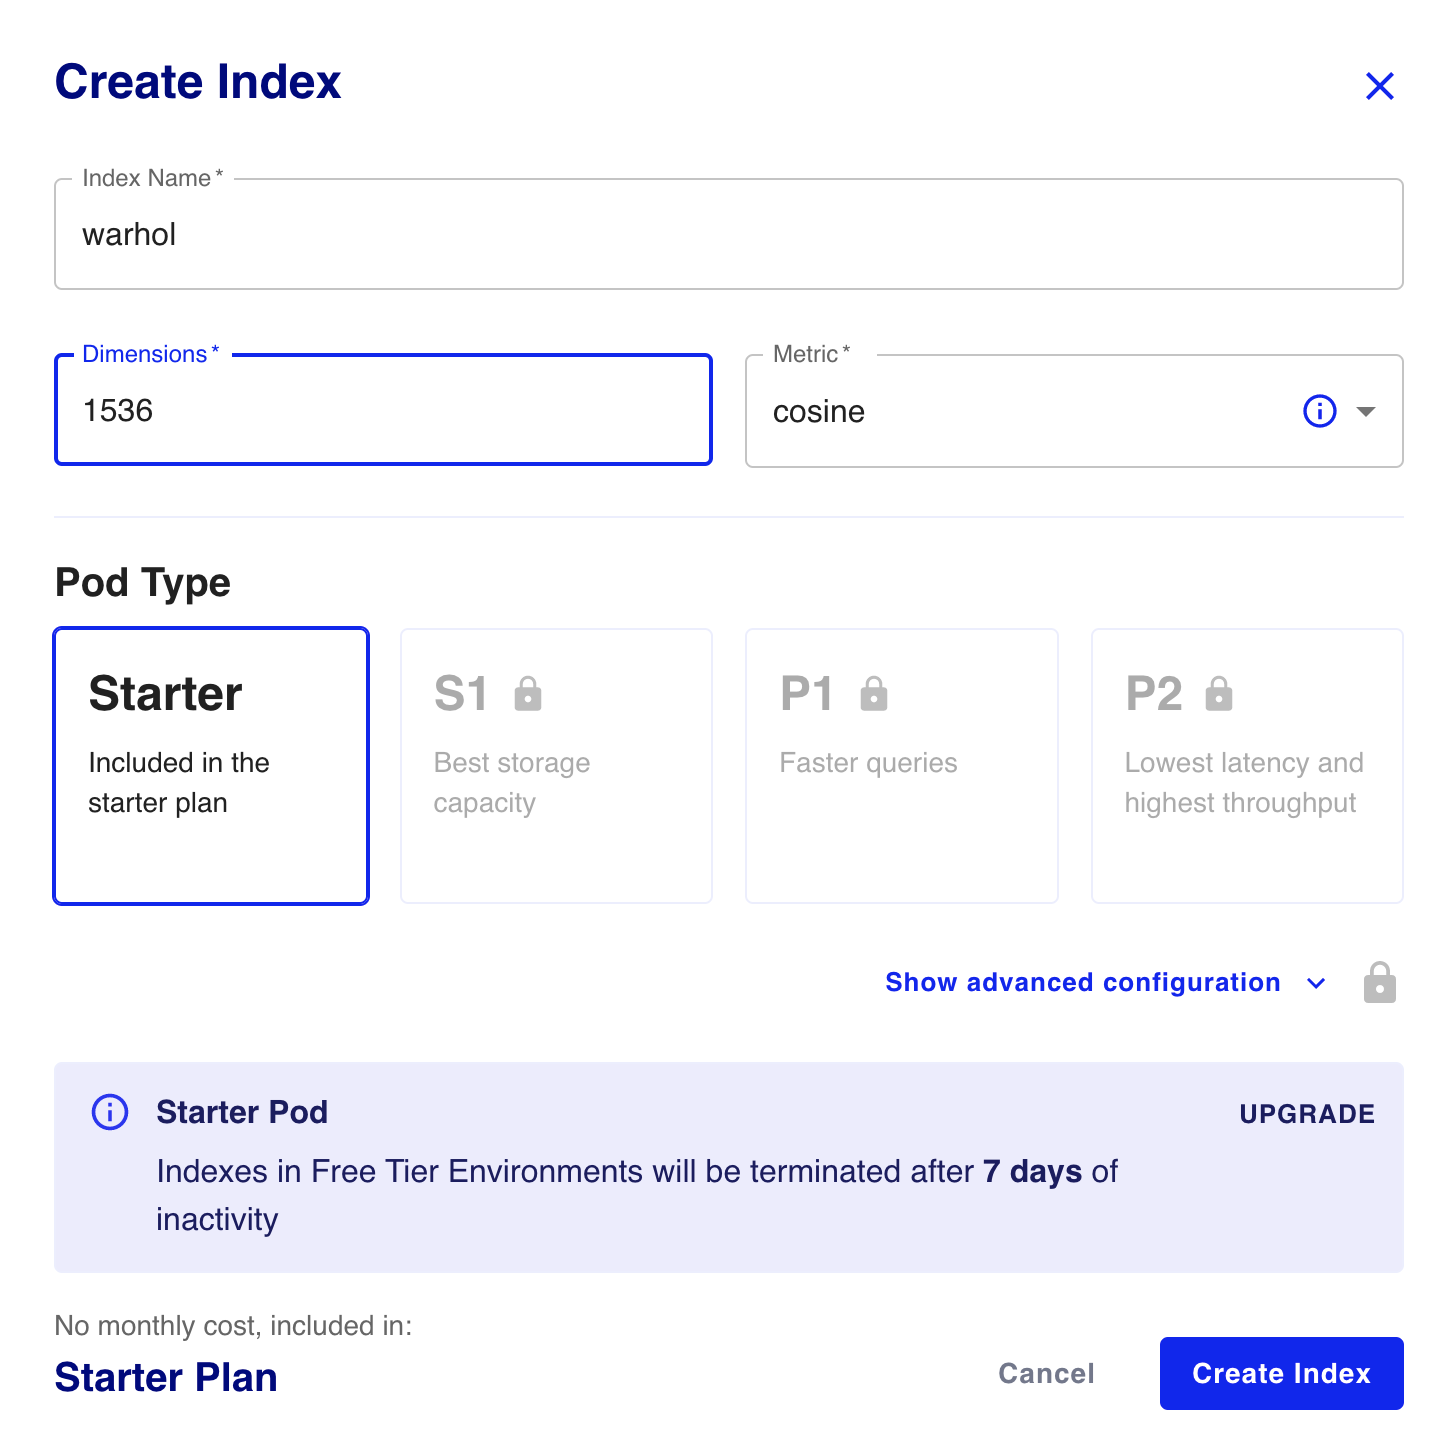


Go to Pinecone and create your index. give it a name, and then note which node your index is located in for the "environment". This must be passed on to set up API access to your index. Give it a name, and set it to 1536 Dimensions. This matches the dimensionality of the embedding model that we are using, `text-embedding-ada-002`.

In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_KEY)

In [ ]:
pinecone.init(
    api_key=PINECONE_KEY,
    environment="..."
)
index_name = 'scotus' #go to Pinecone and show instructions for how to do this

##Step 5 - Generate Embeddings and upload them to Pinecone.
This will incur fees for OpenAPI usage, although new accounts come with some amount of free API credits which you can use without attaching a payment method. Luckily, Ada002 is very inexpensive to use at $0.0004 per 1000 tokens. To estimate the cost of embedding our vectors, multiply 800 character chunks x 323 vectors, then divide by 4000 to get kilotokens, and multiply by .0004. This comes out to about 2.5 cents to encode our single document.

In [ ]:
pip install tiktoken

In [ ]:
docsearch = Pinecone.from_texts([t.page_content for t in texts], embeddings, index_name="scotus")

In [ ]:
#@title (Optional) If you opted to add metadata to your document, you need to specify that here while creating the chunks for Pinecone
docsearch = Pinecone.from_texts([t.page_content for t in texts], embeddings, index_name="scotus", metadatas=[{
    "author": "Neil Gorsuch",
    "source": "https://www.supremecourt.gov/opinions/20pdf/19-292_21p3.pdf",
    "title": "TORRES v. MADRID",
    "year": "2021",
    "subject": "4th Amendment Search and Seizure",
    "opinion": "Dissent"
} for _ in range(len(texts))])

##Now in about a minute we should see data in our Index from Pinecone.
Under "Metrics" you should see a non-zero number of vectors in the vector store.
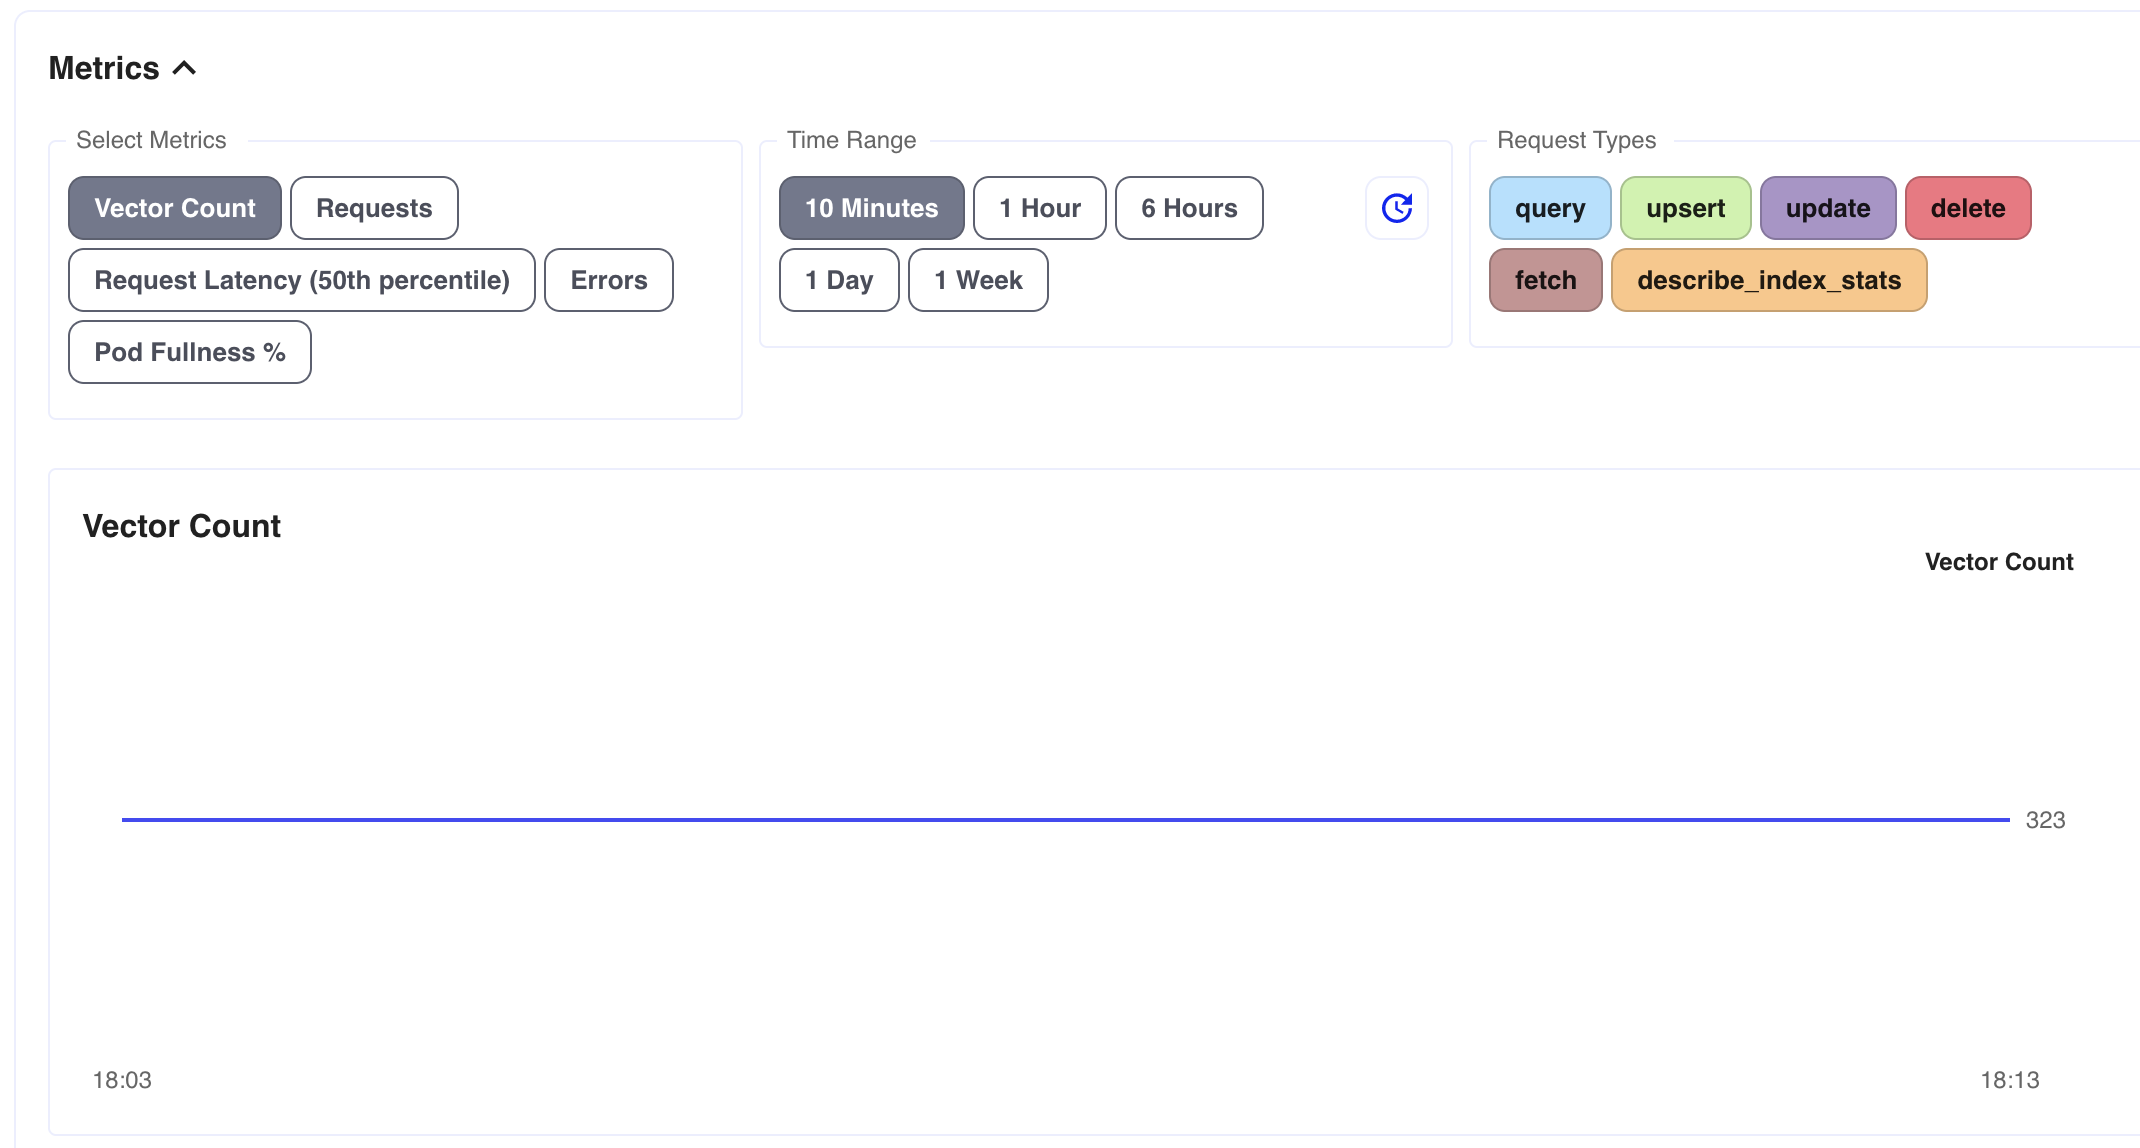

First I'm going to change over our LLM model to use gpt-3.5-turbo	, which is an order of magnitude cheaper than davinci-003, at $0.002 / 1k tokens. I'm cheap. 🤑

In [ ]:
from langchain.llms import OpenAI
from langchain.chains.question_answering import load_qa_chain
#This instruction doesn't appear in most tutorials, but it will allow us to switch the OpenAI
#model we are using from davinci-003 to gpt-3.5-turbo. It performs similarly across a wide range of applications
#and is 1/10 the cost to use. You're welcome.
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate


##(Optional) Custom Prompt Template
This section is optional, but allows us to customize our prompt template. The original Stuff chain prompt appears in commented text, and then a modified prompt appears below that.

If you are a prompt engineering snob, then you might not like how the default prompt is written. In that case, I've included the code to put in your own prompt. Note: you must use the two variables `{question}` and `{context}` somewhere in your prompt, or it will not work in the chain prompt.

In [ ]:
#Let's write a custom Prompt template:
#from langchain import PromptTemplate
#prompt_template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
#{context}
#Question: {question}
#Helpful Answer:"""
#PROMPT = PromptTemplate(
#    template=prompt_template, input_variables=["context", "question"]
#)
#chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff", prompt=PROMPT)
#chain({"input_documents": docs, "question": query}, return_only_outputs=True)

#create custom prompt template to use with Stuff chain query
prompt_template = """
Answer the Question based only on the facts and reasoning found in the Context. You are an analyst providing a detailed legal analysis to the question incorporating all of the information found in the Context.
If you cannot find information relevant to Question in the Context, say that the answer wasn't found.

Question: {question}
Context: {context}"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

## Configuring our llm in langchain
Here I'm using some sensible values. Temperature is set to 0, and max tokens for output is 2048. We are reserving about 1000 tokens for Retrieval Augmentation (up to 5 chunks of text at 800 characters, or 200 tokens), which leaves about 1000 tokens for whatever our prompt consists of. I've set `verbose` to true so that the output from our GPT request will also return the prompt. This helps for seeing what the model was prompted with relative to the completion text.

In [ ]:
#configure model settings
llm = OpenAI(temperature=0, openai_api_key=OPENAI_KEY, model_name="gpt-3.5-turbo", max_tokens=2048)
chain = load_qa_chain(llm, chain_type="stuff", verbose = True)

In [ ]:
#@title (Optional) If you entered a custom prompt above, then use this instruction instead.
llm = OpenAI(temperature=0, openai_api_key=OPENAI_KEY, model_name="gpt-3.5-turbo", max_tokens=2048)
chain = load_qa_chain(llm, chain_type="stuff", verbose = True, prompt=PROMPT)


#Step 6 - Write our Retrieval Prompt and our Generative Prompt
Many of the tutorials I've seen define a single query/prompt variable which first retrieves embeddings, then uses the same prompt for GPT. I'm not a fan of this approach, and I haven't been getting particularly good results. The problem, I believe is that embedding prompts and instruct prompts are not similar in purpose or function. (See generally https://arxiv.org/pdf/2305.12517.pdf)

###Embedding Vectors, Retrieval Prompts and Cosine Similarity

Our Embedding Vectors are 1536-dimensional vectors that numerically encapsulate the semantic meaning of the text chunk that is encoded. In order to match that text chunk in our vector store, we need to produce a prompt that, when encoded using the same function, is going to be spatially near in the 1536-space where our Embeddings live. That means it must be semantically near the Embeddings, or similar in structure and meaning so that it's own encoded value is "pointing in the same direction" as the Embedding vectors. Put another way, to match our Embedding flash cards, our Prompt must "mean" the same as the flash cards.

###Generative Prompts lead to Completion

By contrast, Generative model prompts produce vectors that "complete" the input prompt. They are semantically related, but they often contain very different language, structure and meaning. They aren't of "resemble" the input prompt, and fit into that "back and forth" conversational pattern that makes ChatGPT so entertaining.

So how are we supposed to write a single Prompt that is performant at both tasks, retrieving Embeddings, and Generating interesting Completions? I don't think you can. You get very generic Embedding matches, and very generic Completion text. So I said, "screw it" and just wrote separate Prompts. Turns out I'm not really sure I get how to write Embedding prompts yet. But I'm working on it.

Below I've defined two quiries an embed_query for finding documents and then an instruct_query to ask GPT to do something with that data. In the future, I'm going to get into the prompt templates themselves and see what's going on in more detail.

This first query will let us search our index (the SCOTUS Case) to generate our Embeddings "flash cards".

##Write our embed query
This query will search our vector store and return text snippets based on cosine similarity. Remember here, the text snippets returns must be semantically similar to the text you are trying to retrieve. the `k` paremeter defines how many text samples are returned. Depending on how large your chunk size was, and the context limit of your model, you may need to reduce this in order to not exceed the token limits.

If you opted for adding a metadata dictionary to your pdf and vector store, then the sample filter parameters can be used to control what kinds of documents are returned. I mostly included them so that when I see the text chunks returned I can tell which portion of the opinion they came from.

In [ ]:
embed_query = "arguments regarding arrests in civil suits and the application of Brower to the facts of this case"
docs = docsearch.similarity_search(embed_query, k=6
                                   #, filter={"author": "John Roberts"}
                                   #, filter={"opinion": "Majority"}
                                   )

In [ ]:
docs

##Step 7 - Finally, let's ask GPT about this case!
I've set langchain to produce verbose output so that we can see the chain prompt, followed by the Completion text. You can see that the langchain defaults are putting a bit of prompt language at the beginning and end to try and ground the prompt further into the Embeddings. This can be modified by creating your own prompt templates.

]

In [ ]:
instruct_query = "Provide a thorough analysis of the arguments, reasonings, and conclusions of the Majority and Dissent in the applicability of Brower and arrest in civil suits."
chain.run(input_documents=docs, question=instruct_query)